In [1]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

#### Experiment #1 : Symmetric Convolution


In [2]:
'''model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))'''

"model = VGG16(weights='imagenet',\n                  include_top=False,\n                  input_shape=(224, 224, 3))"

In [3]:
k = 20 # Top 10% highest l2-magnitude filters

(3, 3, 1, 1)


c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:35: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.


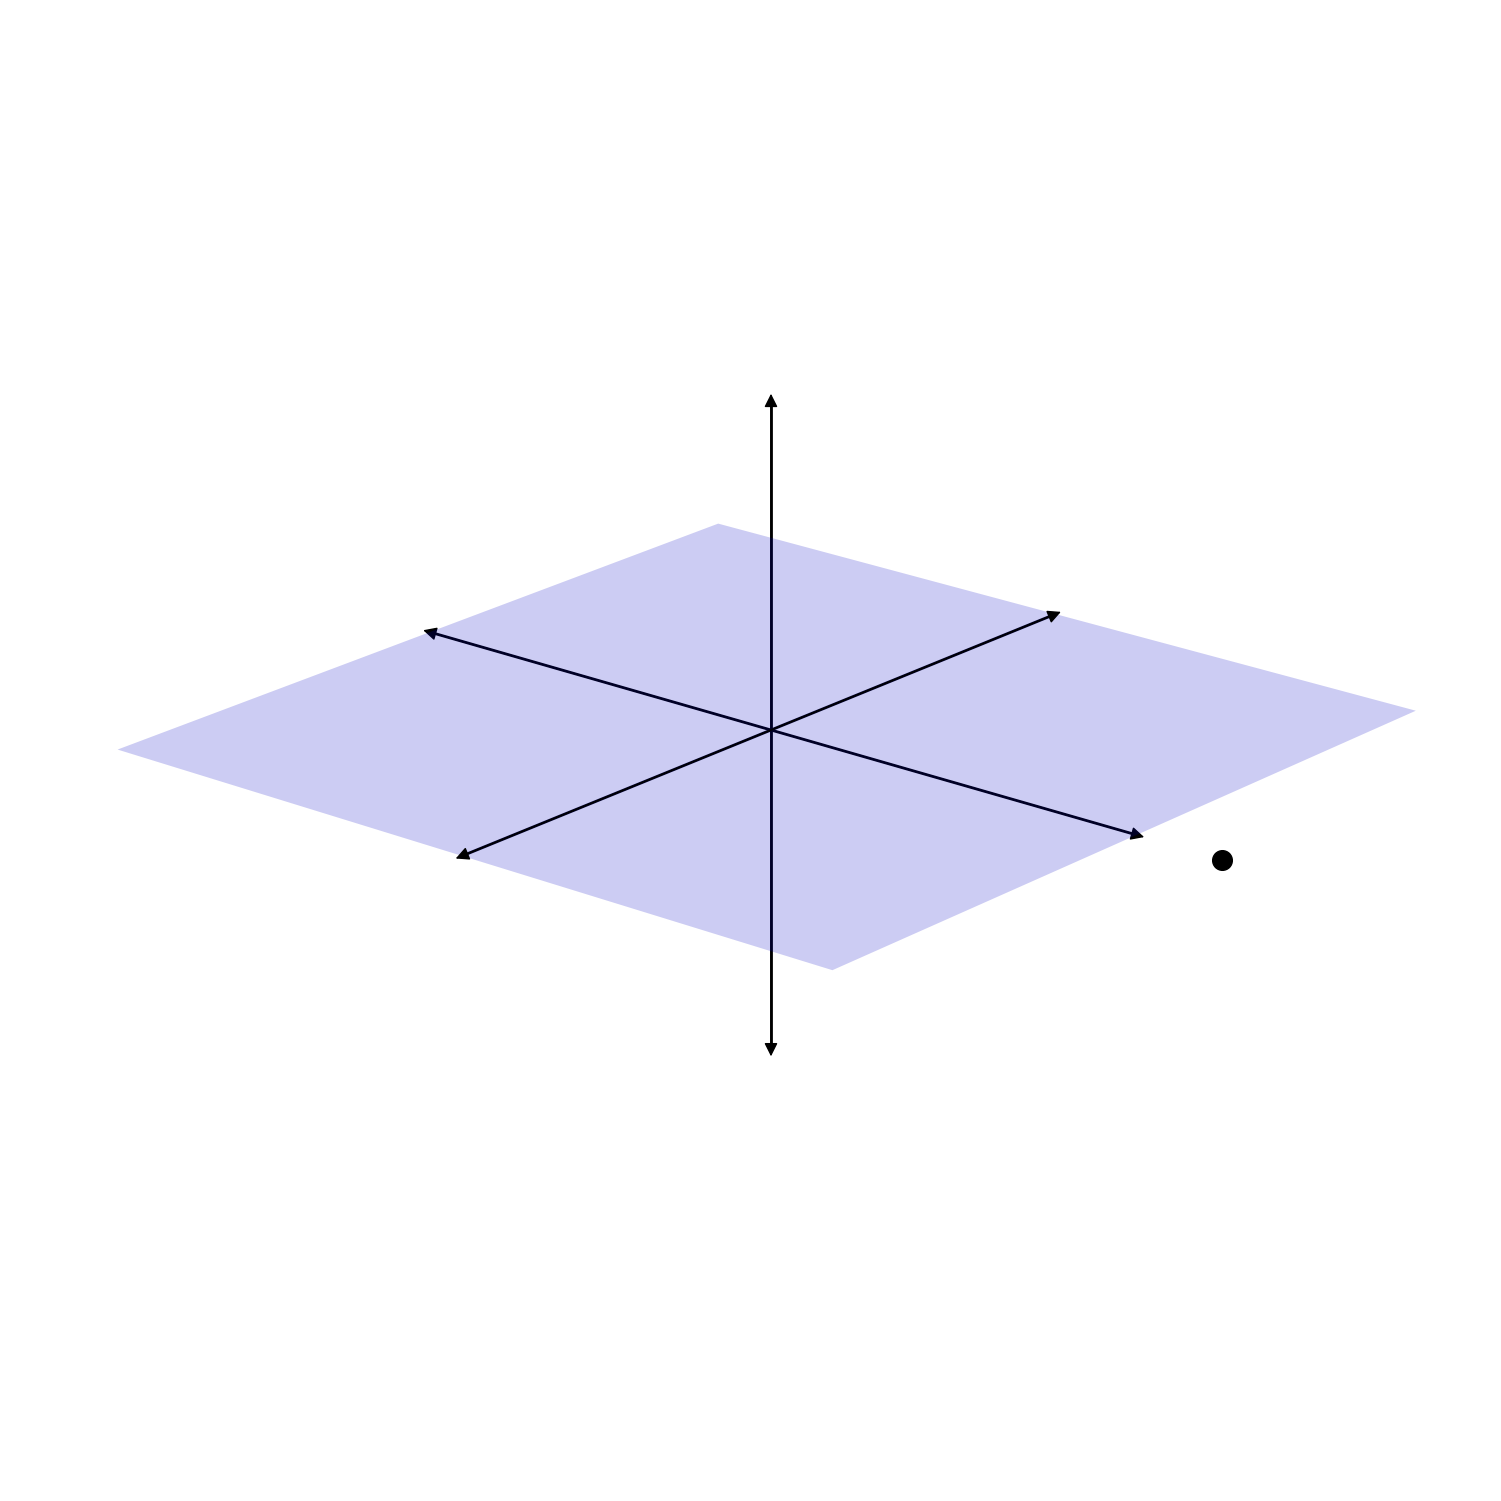

In [4]:
F = 0

filters = np.zeros((3,3,1,1))
filters[:,:,0,0] =  (1/(6))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]]) 


theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)

a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])
mag = reduce_euclidean_norm(filters, axis=[0,1])


x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()
y =( a_mag[:,F]*np.sin((theta[:,F]))).numpy()
z =(s_mag[:,F]*np.sign(np.mean(s, axis=(0,1)))[:,F]).numpy()
plt.rcParams.update({'figure.dpi': '100'})


class Arrow3D(FancyArrowPatch):
	def __init__(self, xs, ys, zs, *args, **kwargs):
		super().__init__((0,0), (0,0), *args, **kwargs)
		self._verts3d = xs, ys, zs

	def do_3d_projection(self, renderer=None):
		xs3d, ys3d, zs3d = self._verts3d
		xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, self.axes.M)
		self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
		return np.min(zs)

	def draw(self, renderer):
		xs3d, ys3d, zs3d = self._verts3d
		xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
		self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
		FancyArrowPatch.draw(self, renderer)

# Create a new figure and a 3D axis
fig = plt.figure(figsize=(15, 15),constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')

# Remove the panes (walls)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Remove the pane lines
ax.xaxis.pane.set_edgecolor('none')
ax.yaxis.pane.set_edgecolor('none')
ax.zaxis.pane.set_edgecolor('none')

# Remove grid lines
ax.grid(False)

# Remove default tick marks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Create the axes lines
axis_length = 10
ax.plot([-1, 1], [0, 0], [0, 0], 'k-', linewidth=2)  # x-axis
ax.plot([0, 0], [-1, 1], [0, 0], 'k-', linewidth=2)  # y-axis
ax.plot([0, 0], [0, 0], [-1, 1], 'k-', linewidth=2)  # z-axis

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the limits for each axis
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

arrow_prop_dict = dict(mutation_scale=20, arrowstyle='<|-|>', shrinkA=0, shrinkB=0)


	
a = Arrow3D([- 1.02, 1.02], [0, 0], [0, 0], **arrow_prop_dict, color='k')
ax.add_artist(a)
a = Arrow3D( [0, 0],[- 1.02, 1.02], [0, 0], **arrow_prop_dict, color='k')
ax.add_artist(a)
a = Arrow3D([0, 0], [0, 0],[-1.02, 1.02], **arrow_prop_dict, color='k')
ax.add_artist(a)


# Color the x,y plane
xx, yy = np.meshgrid(range(-1, 2), range(-1, 2))
ax.plot_surface(xx, yy, np.zeros_like(xx), alpha=0.2, color='blue') 
# Add text to the x,y plane
#ax.text(0, 0, 0, "X-Y Plane", fontsize=14, ha='center', va='center', 
#        zdir='x', zorder=20)# Example: Plot some 3D points
points = np.array([x,y,z]).T*3
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='k', s=200)
plt.axis('off')
# Show the plot

ax.view_init(elev=20, azim=40)

#fig.savefig(f'hand_antisym_unipolar.pdf', dpi=600,  transparent=True, bbox_inches='tight')
plt.show()

#import subprocess
#subprocess.run(["pdfcrop ", f'hand_antisym_unipolar.pdf']) 


In [5]:
#var = 2/(128*9)

img =  cv2.imread('input4.png', 0)/255. 
#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)

(224, 224)


In [6]:
img[120,127]

1.0

In [7]:
x.shape

(1,)

(3, 3, 1, 1)
0
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(0.0, shape=(), dtype=float32) 11.015031
(1, 224, 224, 1)
1
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(19.085197, shape=(), dtype=float32) 0.5023623
(1, 224, 224, 1)
2
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(18.080719, shape=(), dtype=float32) 0.50226057
(1, 224, 224, 1)
3
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(19.085201, shape=(), dtype=float32) 0.50226057
(1, 224, 224, 1)
4
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(18.080719, shape=(), dtype=float32) 0.50226057
(1, 224, 224, 1)
5
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(19.085201, shape=(), dtype=float32) 0.50226057
(1, 224, 224, 1)
6
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(18.080029, shape=(), dtype=float32) 0.50226
(1, 224, 224, 1)
7
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(19.083126, shape=(), dtype=float32) 0.50225616
(1, 224, 224, 1)
8
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(18.076668, shape=(), dtype=float32) 0.502244
(1, 224, 224, 1)
9
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(19.078571, shape=(), dtype=float32) 0.502216

c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(1, 224, 224, 1)
VALS 1.0
tf.Tensor(18.033955, shape=(), dtype=float32) 0.5001587
(1, 224, 224, 1)
21
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(19.034945, shape=(), dtype=float32) 0.4999377
(1, 224, 224, 1)
22
(1, 224, 224, 1)
VALS 0.99999994
tf.Tensor(18.02707, shape=(), dtype=float32) 0.49980837
(1, 224, 224, 1)
23
(1, 224, 224, 1)
VALS 0.99999994
tf.Tensor(19.028267, shape=(), dtype=float32) 0.49982926
(1, 224, 224, 1)
24
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(18.020596, shape=(), dtype=float32) 0.50006855
(1, 224, 224, 1)
25
(1, 224, 224, 1)
VALS 1.0000001
tf.Tensor(19.021976, shape=(), dtype=float32) 0.50060546
(1, 224, 224, 1)
26
(1, 224, 224, 1)
VALS 0.99999994
tf.Tensor(18.014465, shape=(), dtype=float32) 0.50152844
(1, 224, 224, 1)
27
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(19.015993, shape=(), dtype=float32) 0.502932
(1, 224, 224, 1)
28
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(18.008602, shape=(), dtype=float32) 0.504915
(1, 224, 224, 1)
29
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(19.010218, shape=

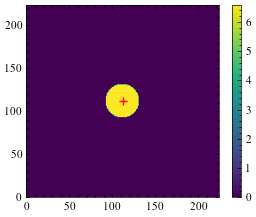

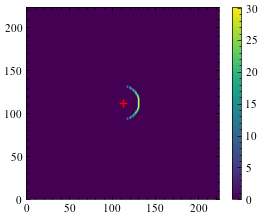

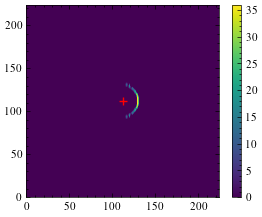

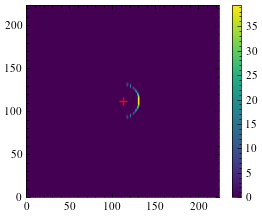

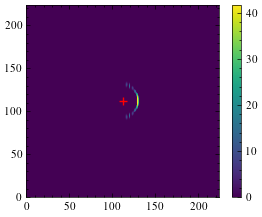

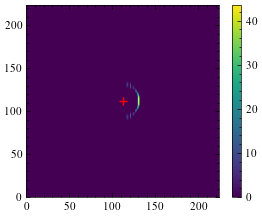

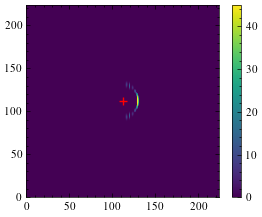

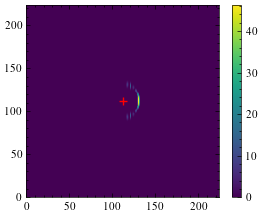

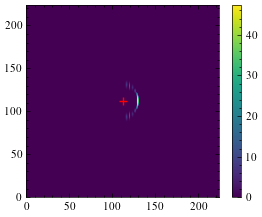

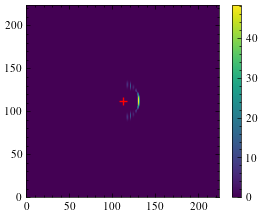

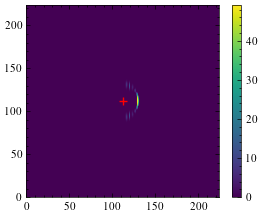

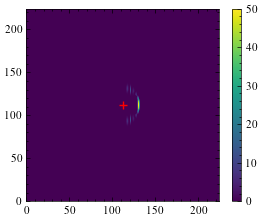

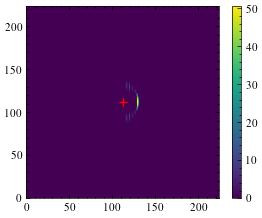

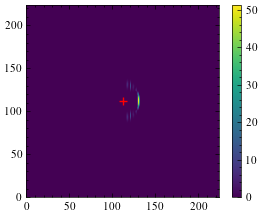

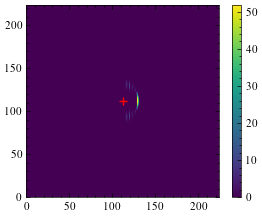

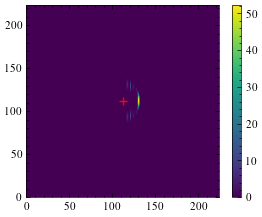

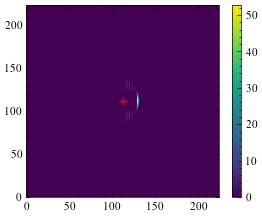

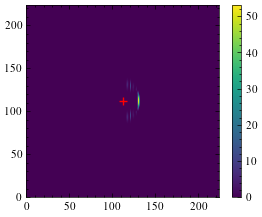

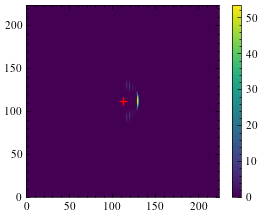

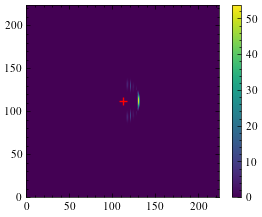

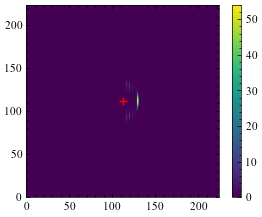

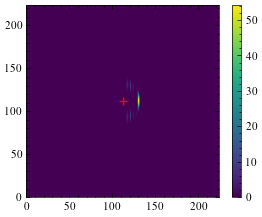

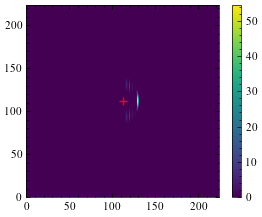

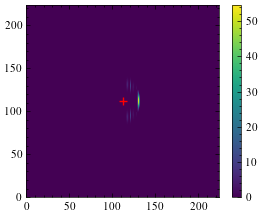

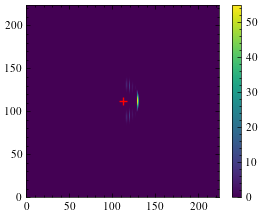

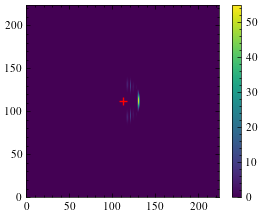

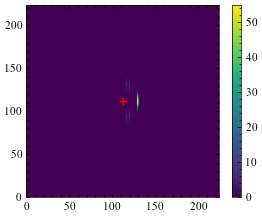

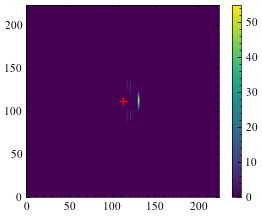

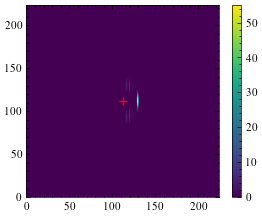

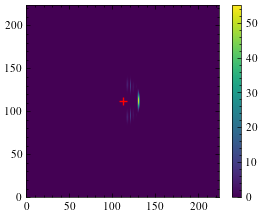

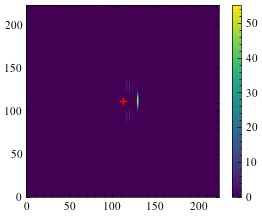

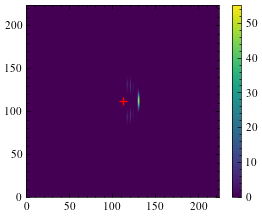

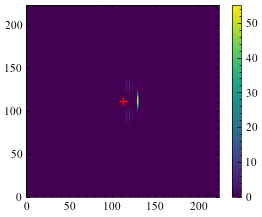

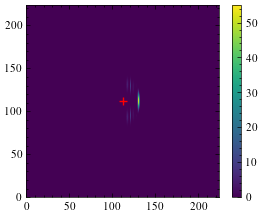

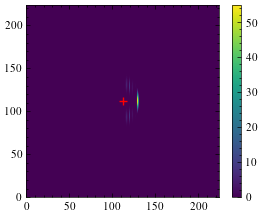

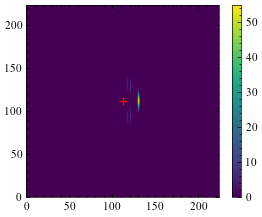

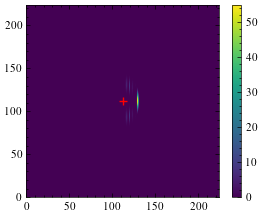

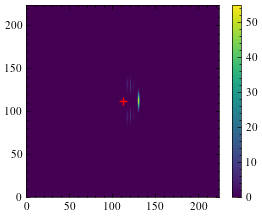

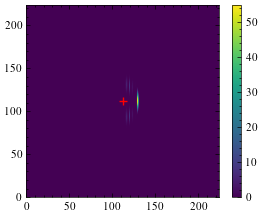

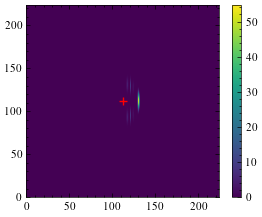

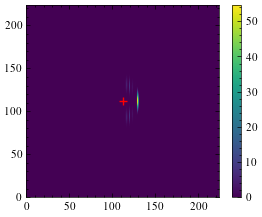

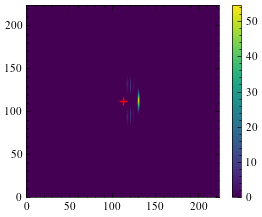

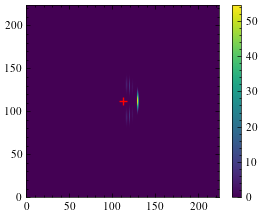

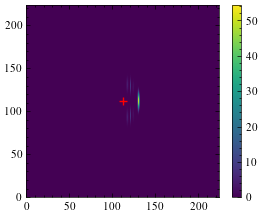

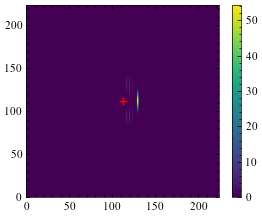

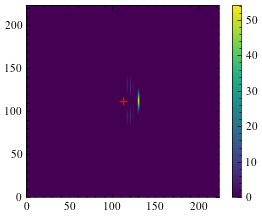

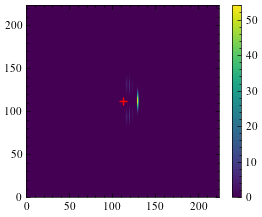

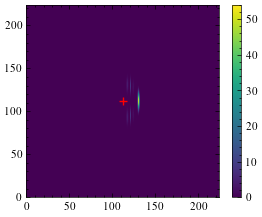

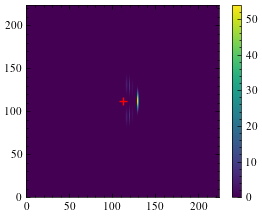

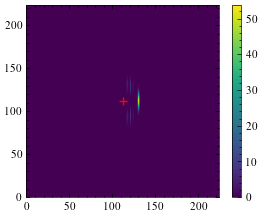

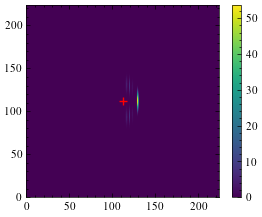

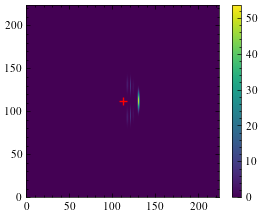

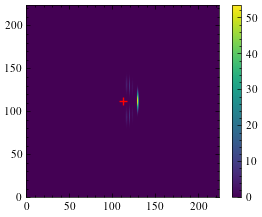

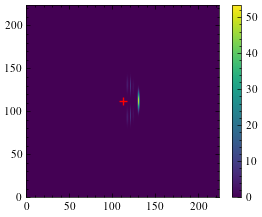

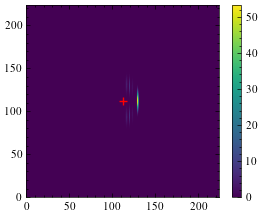

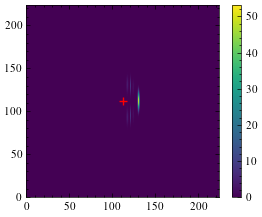

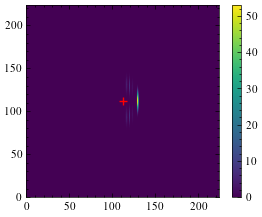

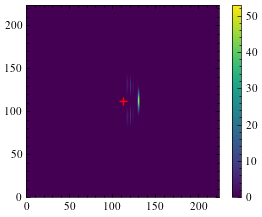

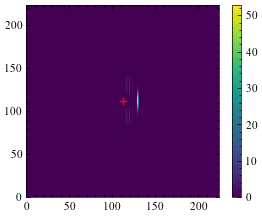

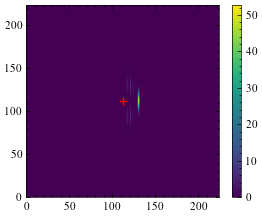

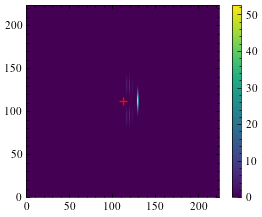

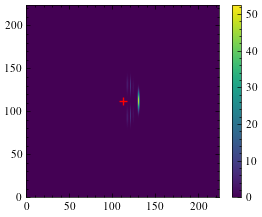

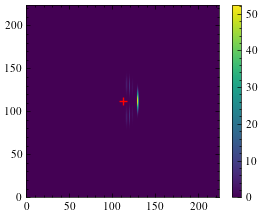

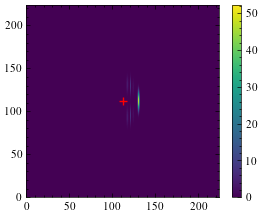

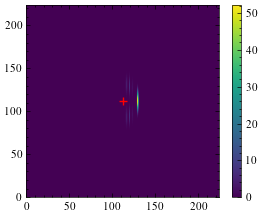

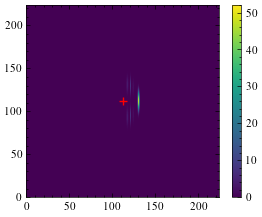

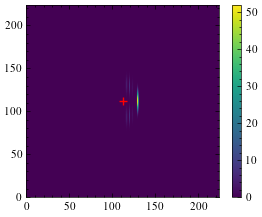

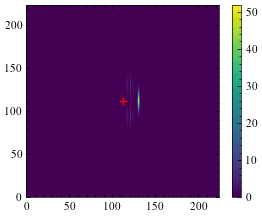

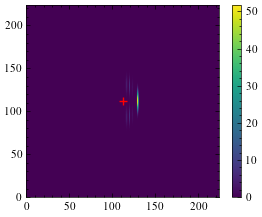

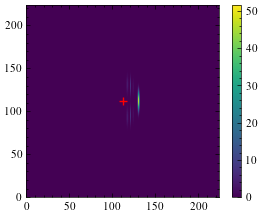

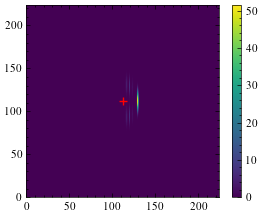

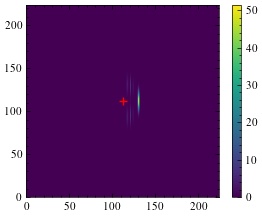

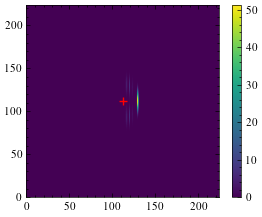

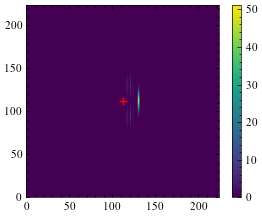

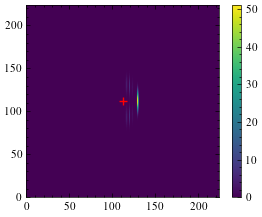

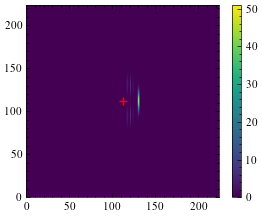

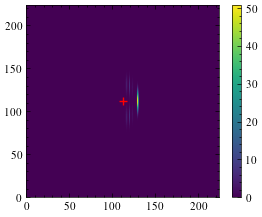

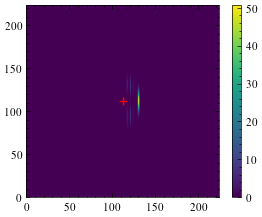

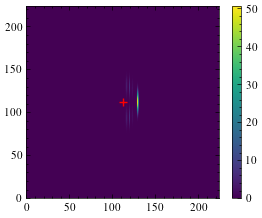

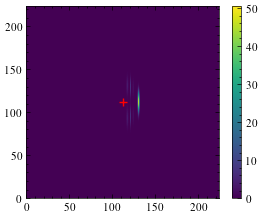

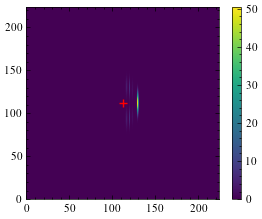

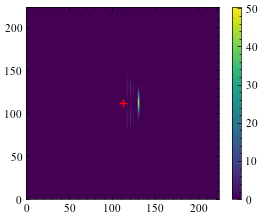

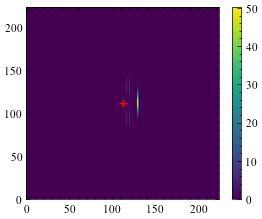

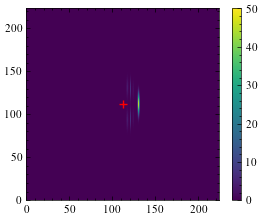

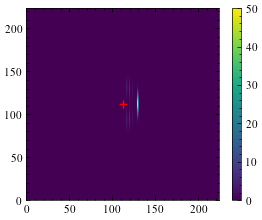

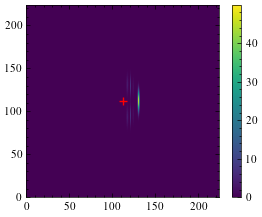

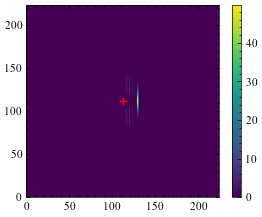

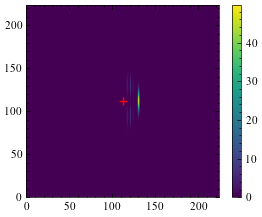

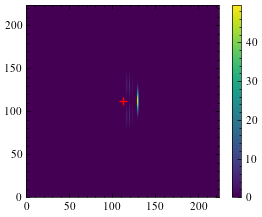

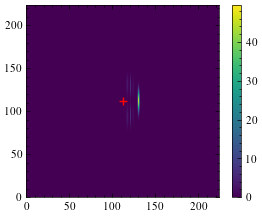

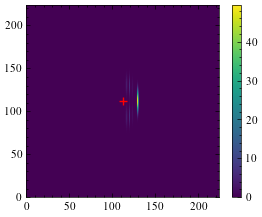

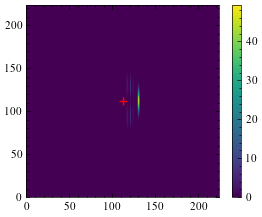

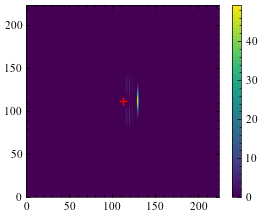

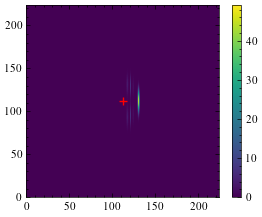

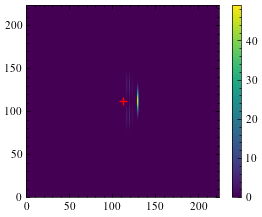

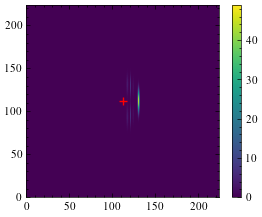

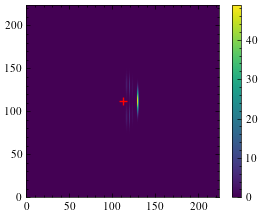

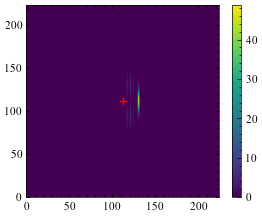

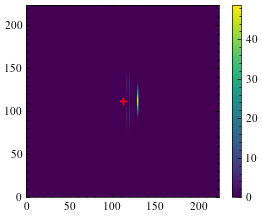

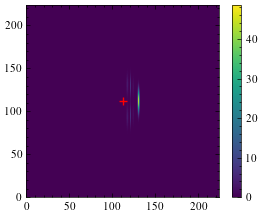

In [8]:
import matplotlib.patches as mpatches

w =tf.cast(filters, dtype=tf.float32)# tf.expand_dims(filters, -1), dtype=tf.float32)
w = tf.transpose(w, perm=(1,0,2,3))
print(w.shape)

x = img


directory = f"figures/hand_antisym_bipolar(flipping)"
if not os.path.exists(directory):
	os.makedirs(directory)
x = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) 
for i in range(100):
	print(i)
	fig, ax = plt.subplots()
	print(x.shape)
	
	x = x/np.std(x)
	vals = x[0, x.shape[1]//2, :, :]
	vals = vals/np.sum(vals)

	print("VALS", np.sum(vals))
	pos = np.expand_dims(np.linspace(-x.shape[1]//2, x.shape[1]//2, x.shape[1]),-1)
	mean = tf.reduce_sum(pos*vals)
	var = tf.reduce_sum(((pos-mean)**2) * vals)
	std = np.sqrt(var)
	print(mean, np.sqrt(var))
	
	#x = tf.repeat(x , repeats = filters.shape[-2], axis=-1)
	print(x.shape)

	im = ax.imshow(np.sum(x[0,:,:,:], axis=-1))
	ax.plot(112, 112, marker = '+', color='red')

	#ax.plot(112+mean, 112, marker = ".", color='black')

	ax.set(xlim=(0, 224), ylim=(0, 224))

	fig.colorbar(im, orientation='vertical')
	fig.savefig(directory + f'/{i}.pdf', dpi=600,  transparent=True, bbox_inches='tight')

	x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
							padding='SAME') )
	w = w*-1
